In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [12]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

In [13]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 100

In [14]:
directory_path = '/content/drive/MyDrive/PlantVillage'

In [15]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2154 files belonging to 3 classes.


In [16]:
class_names = dataset.class_names

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
data_augmentation = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [18]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
resnet_model.trainable = False

inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = resnet_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_dataset
)

Epoch 1/100
54/54 [==============================] - 30s 283ms/step - loss: 0.2614 - accuracy: 0.9120 - val_loss: 0.0770 - val_accuracy: 0.9941
Epoch 2/100
54/54 [==============================] - 8s 143ms/step - loss: 0.0561 - accuracy: 0.9815 - val_loss: 0.0514 - val_accuracy: 0.9941
Epoch 3/100
54/54 [==============================] - 8s 142ms/step - loss: 0.0436 - accuracy: 0.9844 - val_loss: 0.0522 - val_accuracy: 0.9765
Epoch 4/100
54/54 [==============================] - 8s 142ms/step - loss: 0.0307 - accuracy: 0.9878 - val_loss: 0.0311 - val_accuracy: 0.9941
Epoch 5/100
54/54 [==============================] - 8s 143ms/step - loss: 0.0213 - accuracy: 0.9959 - val_loss: 0.0257 - val_accuracy: 0.9941
Epoch 6/100
54/54 [==============================] - 8s 145ms/step - loss: 0.0278 - accuracy: 0.9913 - val_loss: 0.0271 - val_accuracy: 0.9941
Epoch 7/100
54/54 [==============================] - 8s 142ms/step - loss: 0.0229 - accuracy: 0.9936 - val_loss: 0.0476 - val_accuracy: 0.988

In [20]:
test_scores = model.evaluate(test_dataset)

print("Test Accuracy:", test_scores[1])


8/8 [==============================] - 7s 122ms/step - loss: 0.0024 - accuracy: 1.0000
Test Accuracy: 1.0


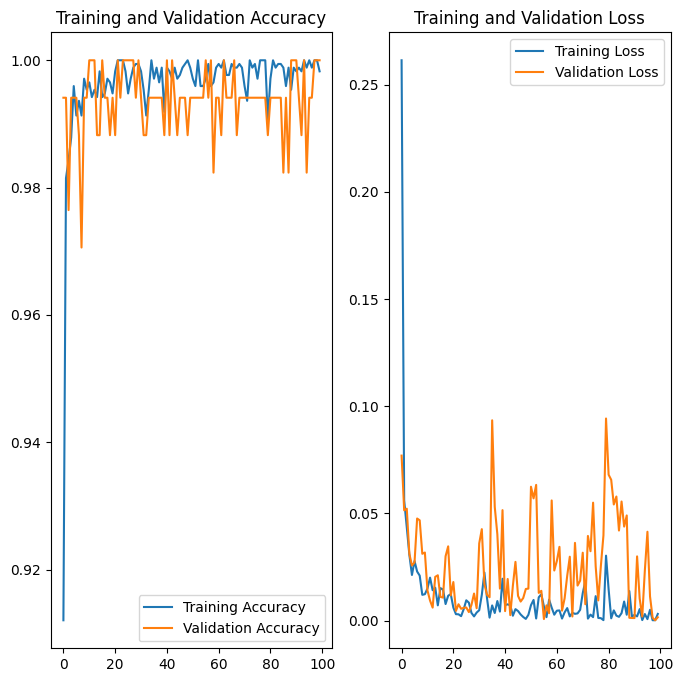

In [21]:
# Plotting training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()